# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

In [4]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


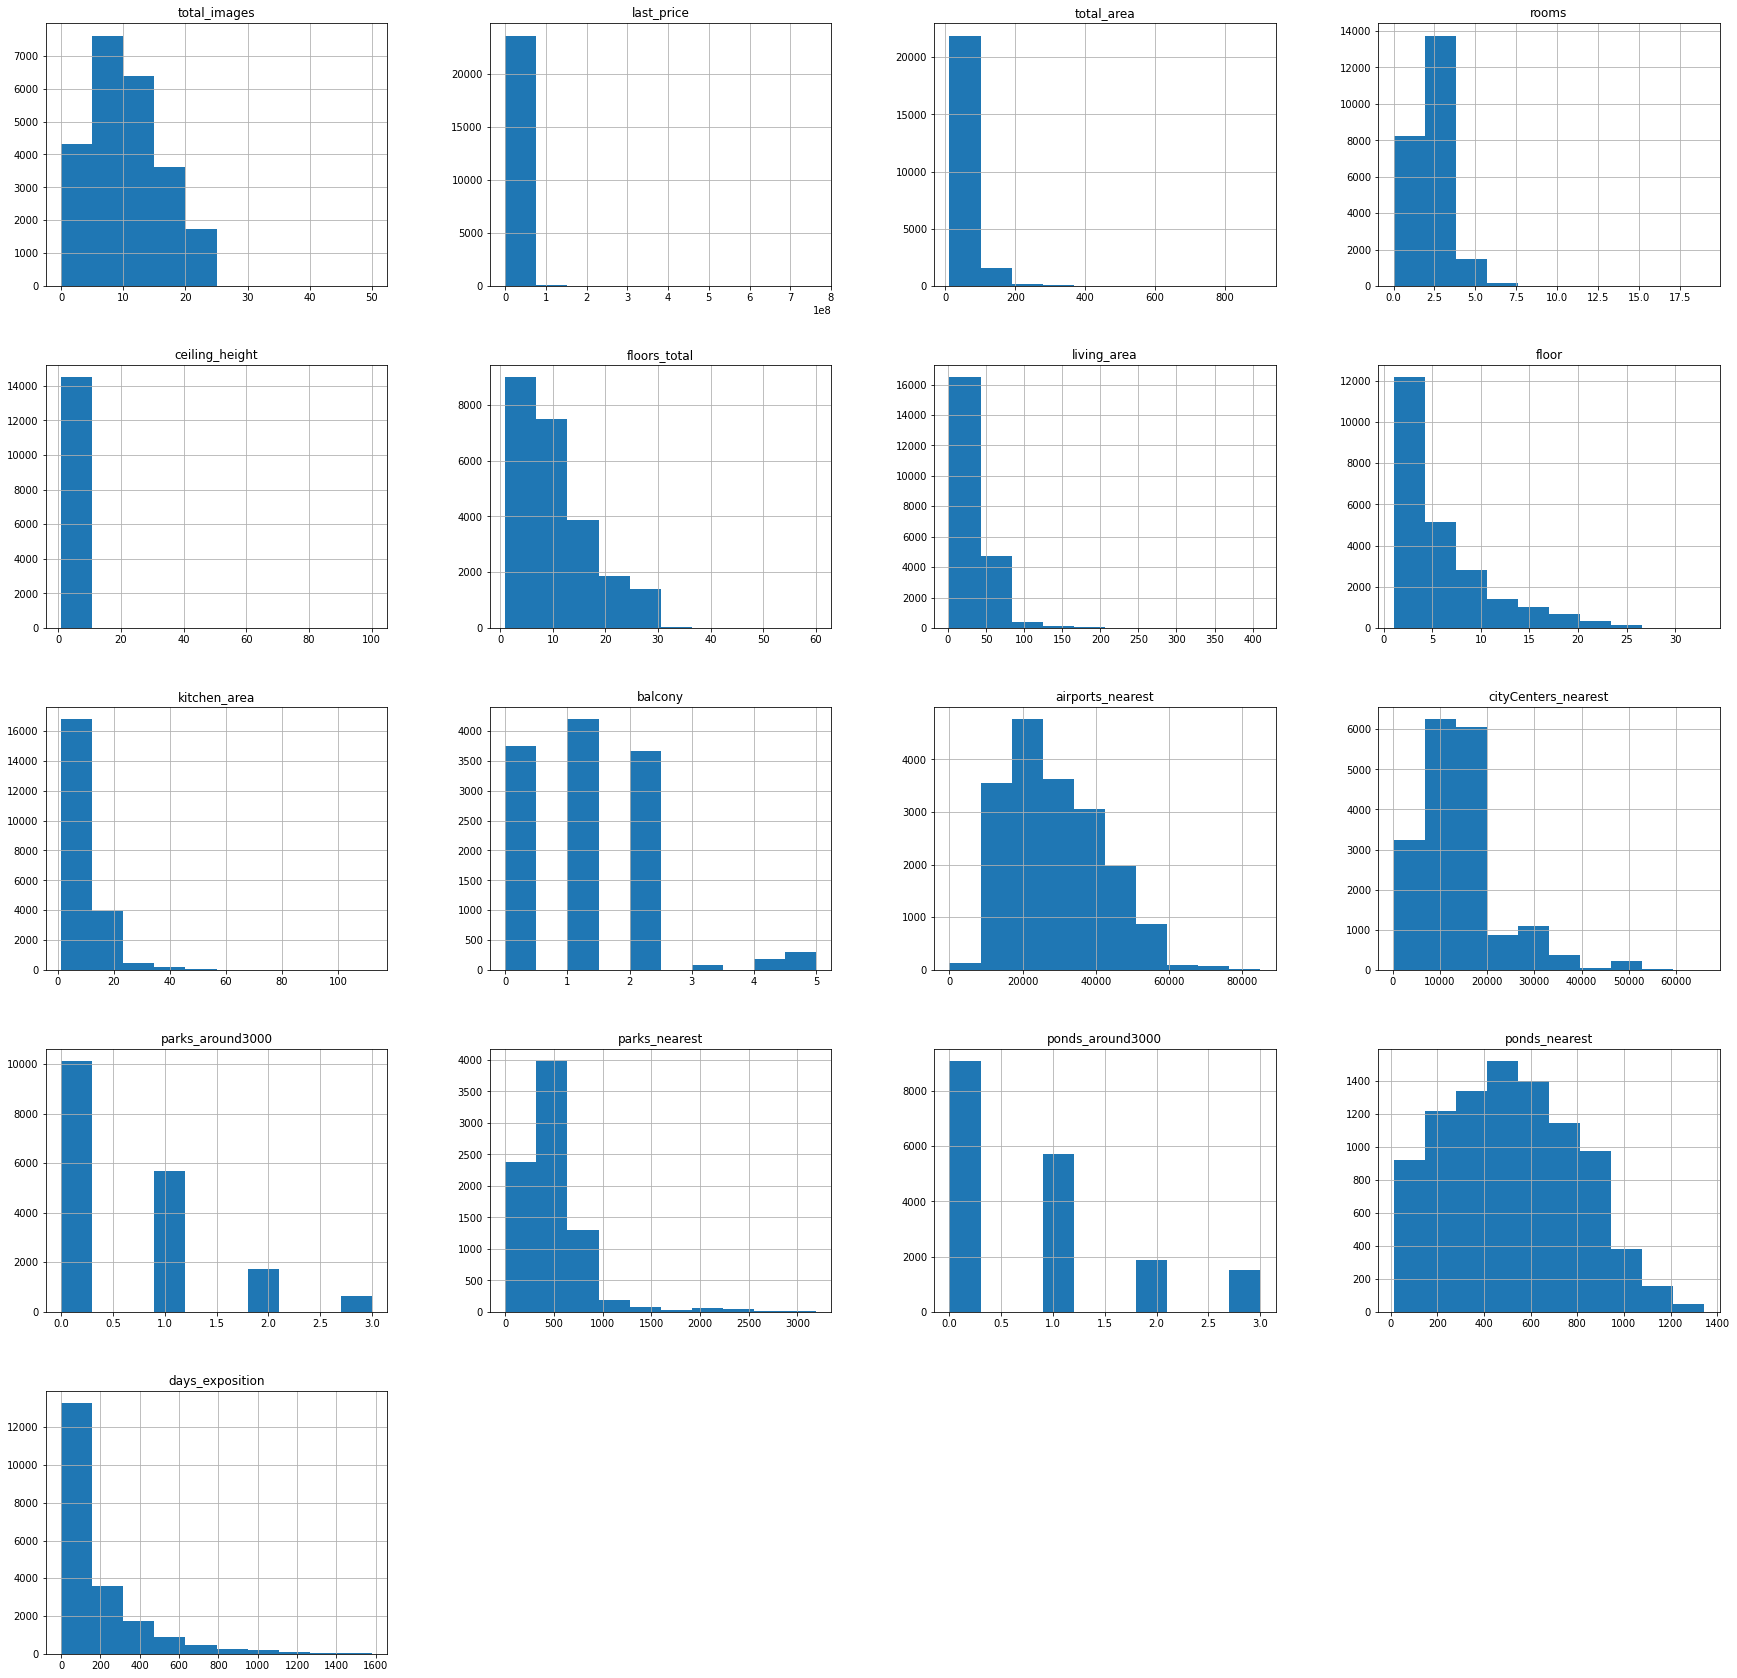

In [3]:
data.hist(figsize=(30, 30))
plt.show()

Здравствуйте, что-то я совсем запуталась... Дайте мне пожалуйста развернутые комментарии к тому, что я неправильно сделала или не сделала. Меня парень бросил и на каждом затыке в задании, я очень расстраиваюсь. Я бы очень хотела доделать проект вовремя и усвоить все знания. Просто если сейчас будет затык, то далее уже проблемно будет продолжать. Все выводы я сделаю, когда доделаю полностью работу. Спасибо!

### Предобработка данных

#### Работа с пропусками в данных

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Пропуски обнаружились в
- ceiling_height - высота потолков - ее могли не указать, так как не смогли измерить.Следовательно, потолки достаточно высокие или наоборот, потолки стандартные и указывать высоту было не обязательно, также, возможен вариант с низкими потолками, поэтому, чтобы продать квартиру, высоту не указали. Оставим без изменений.
- floors_total - количество этажей в доме - есть переменная этаж, можно поработать с этими переменными
- living_area - жилая площадь - из общей площади квартиры вычесть площадь кухни, ванна и санузел занимают небольшую площадь, ими можно пренебречь. Строки для которых нет этих данных - удалить.
- is_apartment - апартаменты или нет - оставить данные без изменений
- kitchen_area - площадь кухни - из общей площади вычесть жилую  
- balcony - число балконов - заменить 0, так как если указали, значит балконов нет
- locality_name - название населенного пункта - оставить без изменений
- airports_nearest - расстояние до ближайшего аэропорта - могли не указать, так как ближайший аэропорт находится очень далеко
- cityCenters_nearest  - расстояние до центра - возможно место находится в маленьком населенном пункте, где нет центра
- parks_around3000 - число парков в ближайших 3 км    
- parks_nearest - расстояние до ближайшего парка   
- ponds_around3000 -    число водоемов в ближайших 3 км
- ponds_nearest - расстояние до ближайшего водоема
- days_exposition - сколько дней было размещено объявление - если не указано, значит до сих пор размещено. Оставляем без изменений


In [6]:
data[data['floors_total'].isna()].head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.20,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.10,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.80,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.60,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.00,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
1930,1,9750000.0,66.77,2016-05-13T00:00:00,2,NaN,NaN,NaN,4,NaN,...,NaN,0.0,Санкт-Петербург,39886.0,10660.0,1.0,2276.0,3.0,244.0,90.0
2392,7,5395770.0,53.00,2017-06-29T00:00:00,2,NaN,NaN,29.00,22,NaN,...,9.00,0.0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,48.0
2846,4,2325000.0,27.80,2016-09-21T00:00:00,1,NaN,NaN,19.40,15,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0
2952,10,6500000.0,54.30,2019-04-23T00:00:00,1,NaN,NaN,22.20,6,NaN,...,12.30,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
3031,9,6400000.0,56.70,2018-03-27T00:00:00,2,NaN,NaN,32.00,12,NaN,...,12.00,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,231.0


Можно предположить, что там, где не указано количество этажей в доме, а в столбце этаж указано 1, будет всего 1 этаж, но просмотрев пару значений в таблице видим, что и для 8, 9 этажей общее их количество в доме не указано. Оставим без изменений.


Сначала проработаем с пропусками, которые можно отредактировать, а затем удалим строки с пропущенными значениями в жилой площади и площади кухни, так как они составляют менее 10%

In [7]:
data.loc[data['living_area'].isna(),'living_area'] = data['total_area'] - data['kitchen_area']
data['living_area'].isna().sum()
data['living_area'] = data['living_area'].dropna().reset_index(drop=True)

In [8]:
data.loc[data['kitchen_area'].isna(),'kitchen_area'] = data['total_area'] - data['living_area']
data['kitchen_area'].isna().sum()
data['living_area'] = data['living_area'].dropna().reset_index(drop=True)

Балконы:

In [9]:
data.loc[data['balcony'].isna(),'balcony'] = 0
data['balcony'].isna().sum()

0

In [10]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,6.000000
floor,0.000000
is_apartment,88.000000


In [11]:
for locality_name in data['locality_name'].unique():  #пройдемся по всем уникальным значениям населенных пунктов
    median = data.loc[data['locality_name'] == locality_name,'ceiling_height'].median() #найдем медиану для конкретного населенного пункта
     #присваиваем значение, если есть пропуск
data.loc[data['ceiling_height'].isna(),'ceiling_height'] = data['ceiling_height'].median()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

In [12]:
data.loc[(data['is_apartment'].isna()),'is_apartment'] = False

#### Изменение типов данных

Посмотрев на исходные данные, понимаем, что нужно заменить дату и время специальный тип datetime

In [13]:
data['first_day_exposition'].head()  

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
Name: first_day_exposition, dtype: object

In [14]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition'] 

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

Также нужно заменить высоту потолков на тип float


In [15]:
data['ceiling_height'] = pd.to_numeric(data['ceiling_height'], errors='ignore')
data['ceiling_height']

0        2.70
1        2.65
2        2.65
3        2.65
4        3.03
         ... 
23694    3.70
23695    2.65
23696    2.65
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           22235 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23558 non-null  float64       
 13  balcony         

In [17]:
data['balcony'] = data['balcony'].astype('int')
data['balcony']

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23699, dtype: int64

#### Работа с дубликатами

In [18]:
data.duplicated().sum()

0

Явных дубликатов в данных нет. Найдем и избавимся от неявных дубликатов, для этого создам функцию, которая уберет типы поселений(деревня, поселок и тд).

In [19]:
sorted(data['locality_name'].astype('str').unique())

['nan',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 

In [20]:
def replace_locality_name(locality_name):
    locality_name = locality_name.str.replace('поселок городского типа ','')
    locality_name = locality_name.str.replace('посёлок городского типа ','')
    locality_name = locality_name.str.replace('городской поселок ','')
    locality_name = locality_name.str.replace('городской посёлок ','')
    locality_name = locality_name.str.replace('коттеджный поселок ','')
    locality_name = locality_name.str.replace('коттеджный посёлок ','')
    locality_name = locality_name.str.replace('посёлок ','')
    locality_name = locality_name.str.replace('поселок ','')
    locality_name = locality_name.str.replace('деревня ','')
    locality_name = locality_name.str.replace('село ','')
    locality_name = locality_name.str.replace('село ','')
    locality_name = locality_name.str.replace('Пансионат ','')
    locality_name = locality_name.str.replace('Садовое товарищество ','')
    locality_name = locality_name.str.replace('садовое товарищество ','')
    locality_name = locality_name.str.replace('садоводческое некоммерческое товарищество ','')
    locality_name = locality_name.str.replace('при железнодорожной станции ','')
    locality_name = locality_name.str.replace('станции ','')
    return locality_name
data['locality_name'] = replace_locality_name(data['locality_name'].copy())
sorted(data['locality_name'].astype('str').unique())

['nan',
 'Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпосёлок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зелёный Бор',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичёво'

#### Работа с аномальными значениями

<AxesSubplot:ylabel='Frequency'>

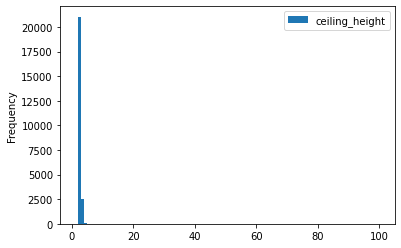

In [21]:
data.plot(y='ceiling_height',kind='hist',bins=100)

Чтобы найти аномальные значения, выведу минимальные и максимальные значения по всем столбцам

In [22]:
data.max()

total_images                             50
last_price                      763000000.0
total_area                            900.0
first_day_exposition    2019-05-03 00:00:00
rooms                                    19
ceiling_height                        100.0
floors_total                           60.0
living_area                           571.0
floor                                    33
is_apartment                           True
studio                                 True
open_plan                              True
kitchen_area                         462.75
balcony                                   5
airports_nearest                    84869.0
cityCenters_nearest                 65968.0
parks_around3000                        3.0
parks_nearest                        3190.0
ponds_around3000                        3.0
ponds_nearest                        1344.0
days_exposition                      1580.0
dtype: object

In [23]:
data.min()

total_images                              0
last_price                          12190.0
total_area                             12.0
first_day_exposition    2014-11-27 00:00:00
rooms                                     0
ceiling_height                          1.0
floors_total                            1.0
living_area                             2.0
floor                                     1
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                         -352.0
balcony                                   0
airports_nearest                        0.0
cityCenters_nearest                   181.0
parks_around3000                        0.0
parks_nearest                           1.0
ponds_around3000                        0.0
ponds_nearest                          13.0
days_exposition                         1.0
dtype: object

- Высота потолков не может быть менее 2м и более 3, в данных ошибка.
- Жилая площадь не может быть 2м, согласно жилищному кодексу РФ - минимальная площадь на одного человека должна быть более 12 квадратных метров.

In [24]:
data.loc[data['ceiling_height'] > 20,'ceiling_height'] = data.loc[data['ceiling_height'] > 20,'ceiling_height'] /10
data['ceiling_height'] = data.loc[(data['ceiling_height'] < 3) & (data['ceiling_height'] > 2), 'ceiling_height']

In [25]:
data['living_area'] = data.loc[data['living_area'] > 12, 'living_area']

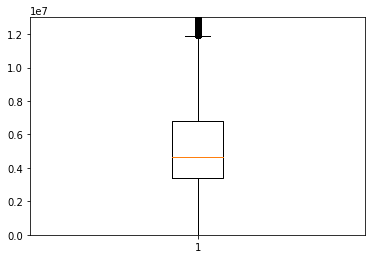

In [26]:
plt.boxplot(data['last_price'])
plt.ylim(0, 13000000)
plt.show()

В ходе предобработки данных были:
- удалены пропуски
- заменены пропуски на медианное значение по группе
- изменены некоторые типы данных
- удалены дубликаты
- удалены аномальные значения

### Посчитайте и добавьте в таблицу новые столбцы

In [27]:
data['price_metr'] = data['last_price'] / data['total_area']#добавила столбец цена за метр квадратный
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,32.0,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
4,2,10000000.0,100.0,2018-06-19,2,NaN,14.0,14.4,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000


In [28]:
data['weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday #добавила столбец месяц
data['weekday'].head()

0    3
1    1
2    3
3    4
4    1
Name: weekday, dtype: int64

In [29]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month #добавила столбец месяц
data['month'].head()

0     3
1    12
2     8
3     7
4     6
Name: month, dtype: int64

In [30]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year #добавила столбец год
data['year'].head()

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year, dtype: int64

In [31]:
def type_floor(row):#функция для определения типа этажа: первый,последний,другой
    if row['floor'] == 1:
        return 'первый'
    if  row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['type_floor'] = data.apply(type_floor,axis = 1)
data['type_floor']

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: type_floor, Length: 23699, dtype: object

Расстояние до центра города в километрах 

In [32]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
data['cityCenters_nearest_km']

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest_km, Length: 23699, dtype: float64

### Проведите исследовательский анализ данных

<AxesSubplot:>

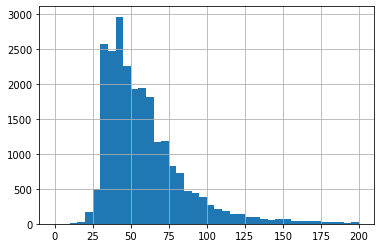

In [33]:
data['total_area'].hist(bins=40,range = (0,200))

Общая площадь в основном лежит в диапазоне от 30 до 100 метров квадратных.Пик в 40 м2

<AxesSubplot:>

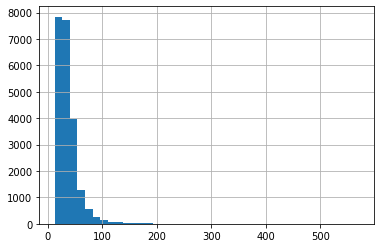

In [34]:
data['living_area'].hist(bins=40)

Жилая площадь в основном лежит в диапазоне от 10 до 50 метров квадратных. Пик в 50м2.


<AxesSubplot:>

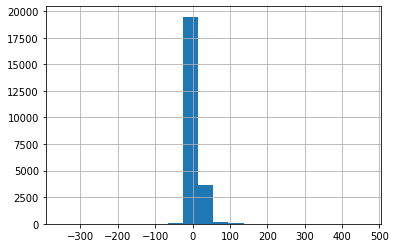

In [35]:
data['kitchen_area'].hist(bins=20)

Площадь кухни от 0 до 25м2


<AxesSubplot:>

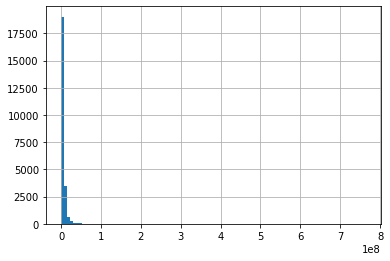

In [36]:
data['last_price'].hist(bins=100)

Странные данные, высокий пик в 0.

<AxesSubplot:>

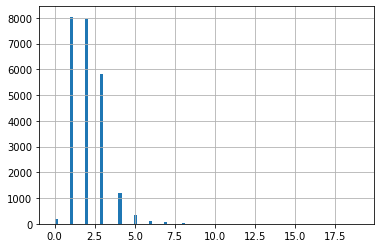

In [37]:
data['rooms'].hist(bins=100)

Большинство квартир однокомнатные. На втором месте квартиры с 2-мя комнатами.

<AxesSubplot:>

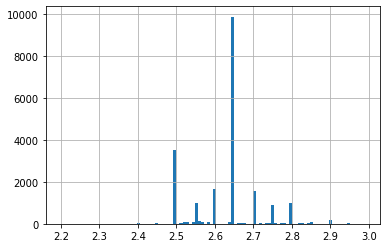

In [38]:
data['ceiling_height'].hist(bins=100)

Большинство потолков стандартные, примерно 2.6 м.

<AxesSubplot:>

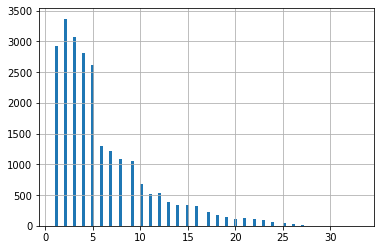

In [39]:
data['floor'].hist(bins=100)

Люди продают квартиры от 0 до 5 этажа чаще, чем квартиры на более высоких этажах.

<AxesSubplot:>

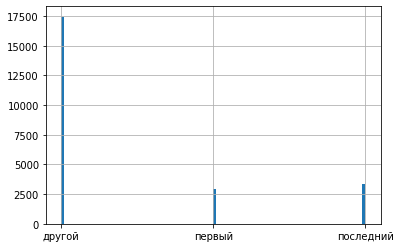

In [40]:
data['type_floor'].hist(bins=100)

Люди не любят покупать жилье на 1 и последнем этажах

<AxesSubplot:>

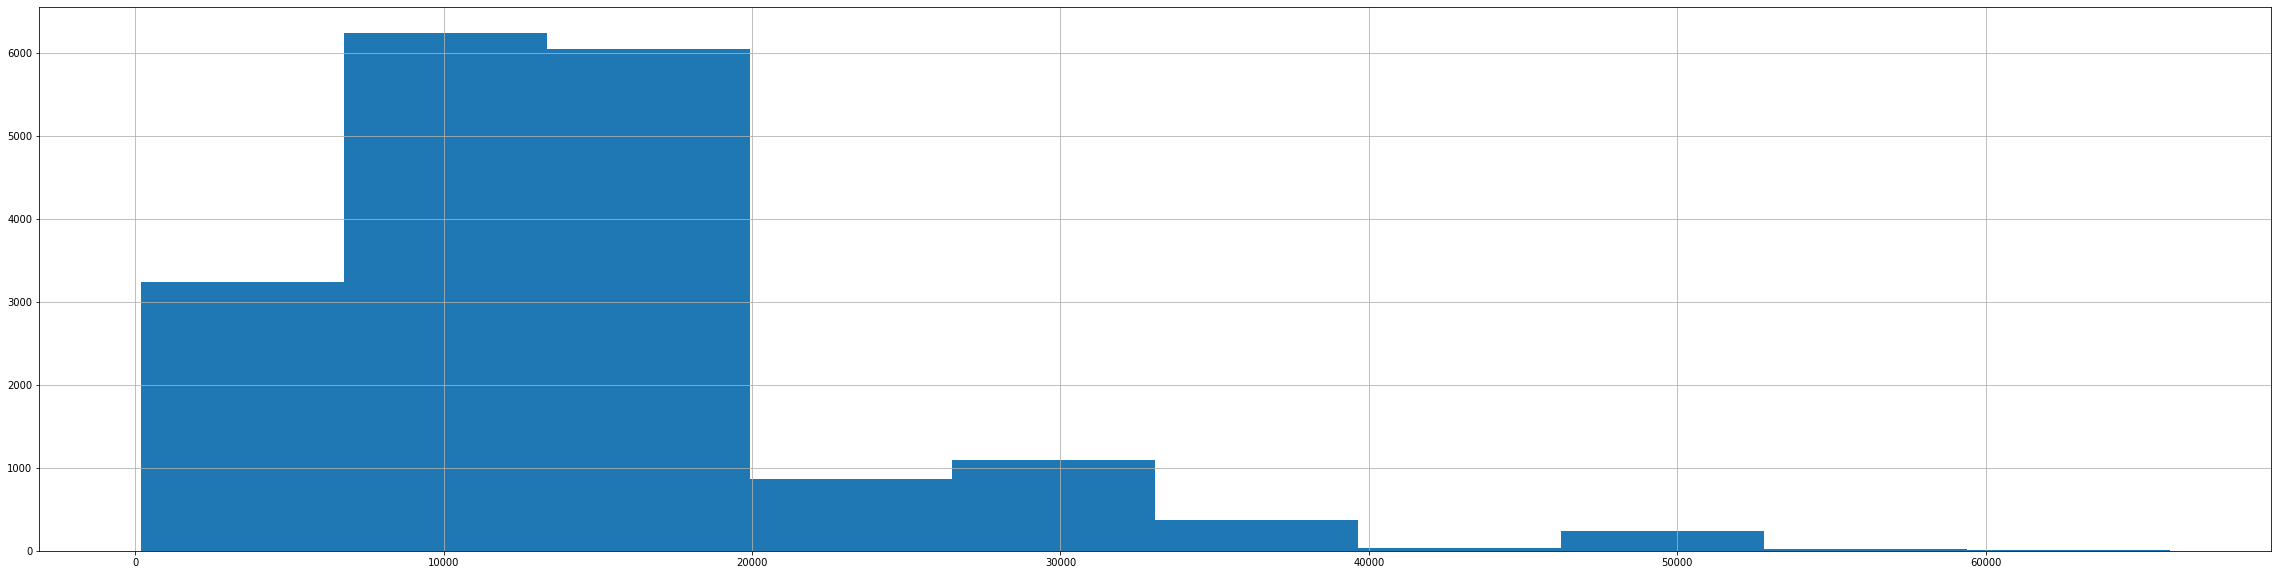

In [41]:
data['cityCenters_nearest'].hist(bins=10,figsize=(40,10))

Квартиры расположенные на среднем расстоянии от центра продают чаще, чем остальные. Люди предпочитают жить в квартирах, расположенных либо близко к центру, либо очень далеко(за городом).

<AxesSubplot:>

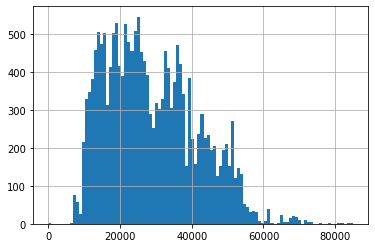

In [42]:
data['airports_nearest'].hist(bins=100)

<AxesSubplot:>

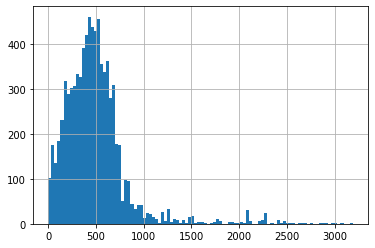

In [43]:
data['parks_nearest'].hist(bins=100)

Парки находятся в радиусе 3 км от места жительства.

<AxesSubplot:>

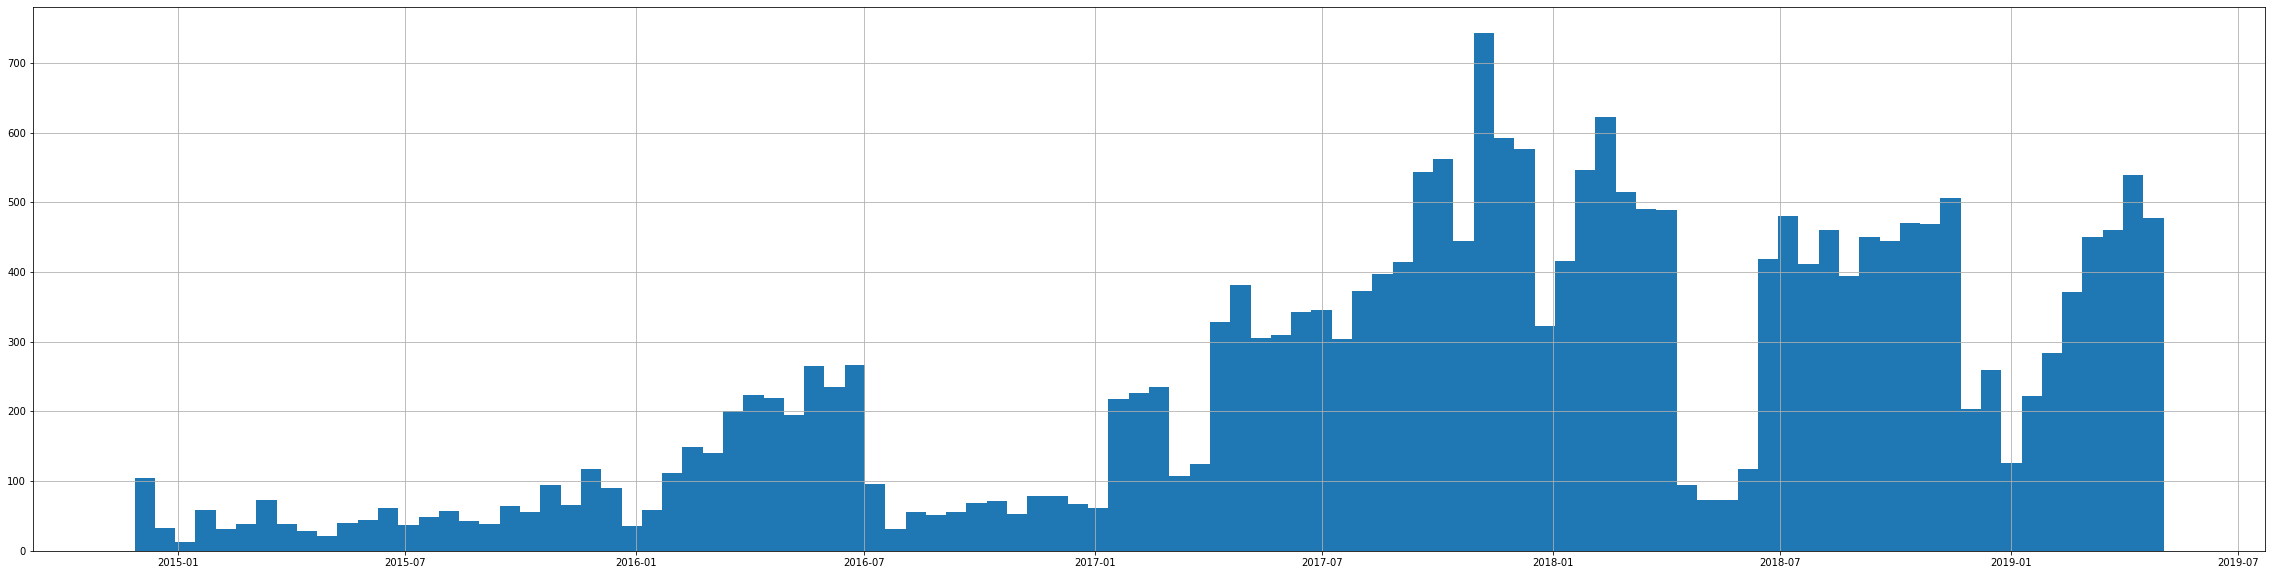

In [44]:
data['first_day_exposition'].hist(bins=100,figsize=(40,10))

Со временем виден рост размещения объявлений.

<AxesSubplot:>

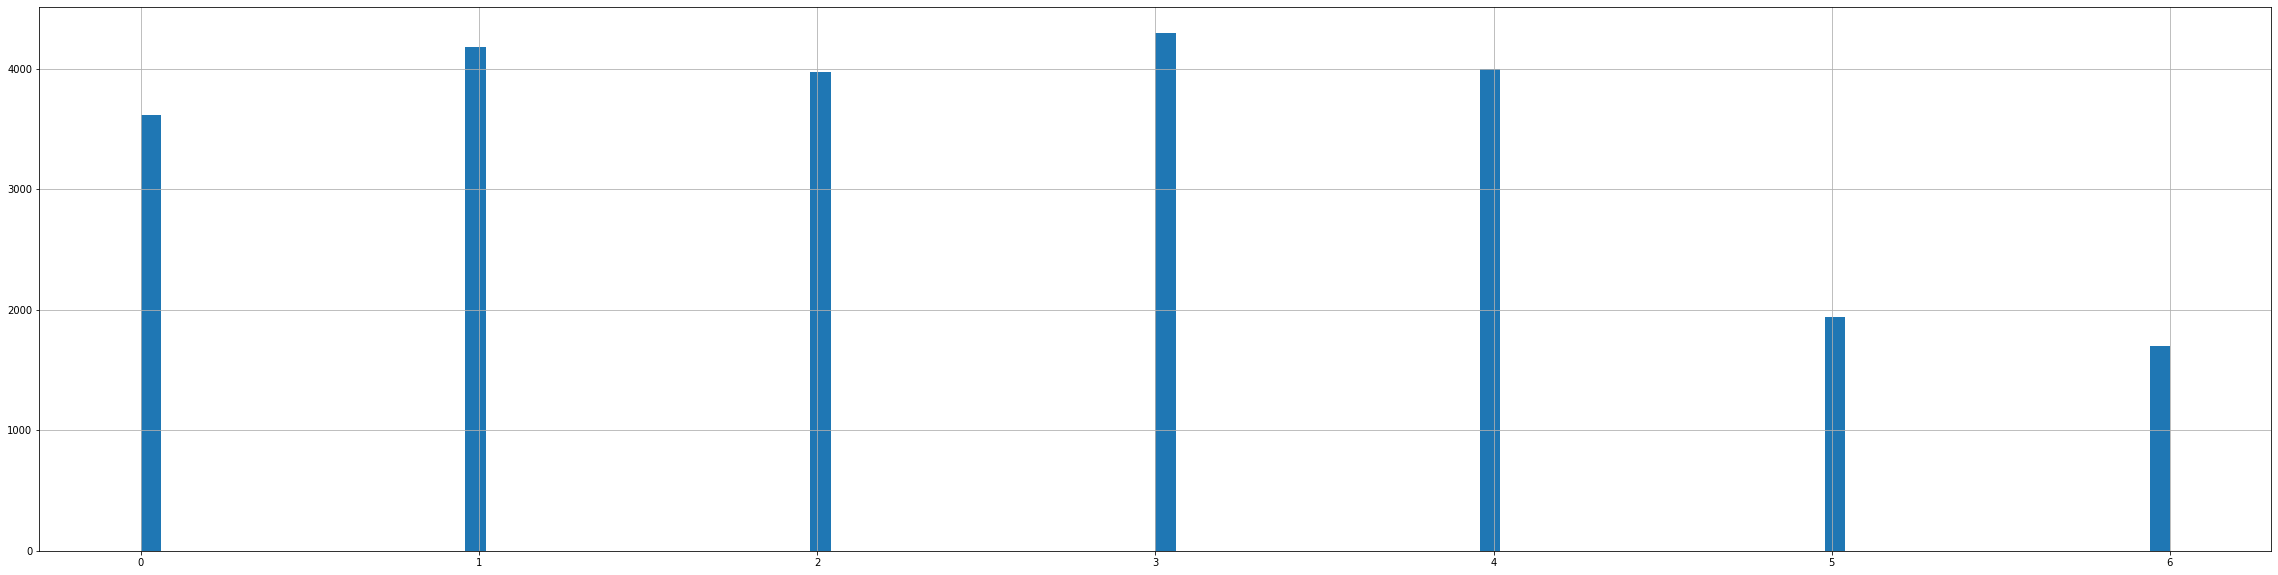

In [45]:
data['weekday'].hist(bins=100,figsize=(40,10))

Квартиры лучше продаются в четверг и вторник, а вот на выходных шансы значительно ниже

<AxesSubplot:>

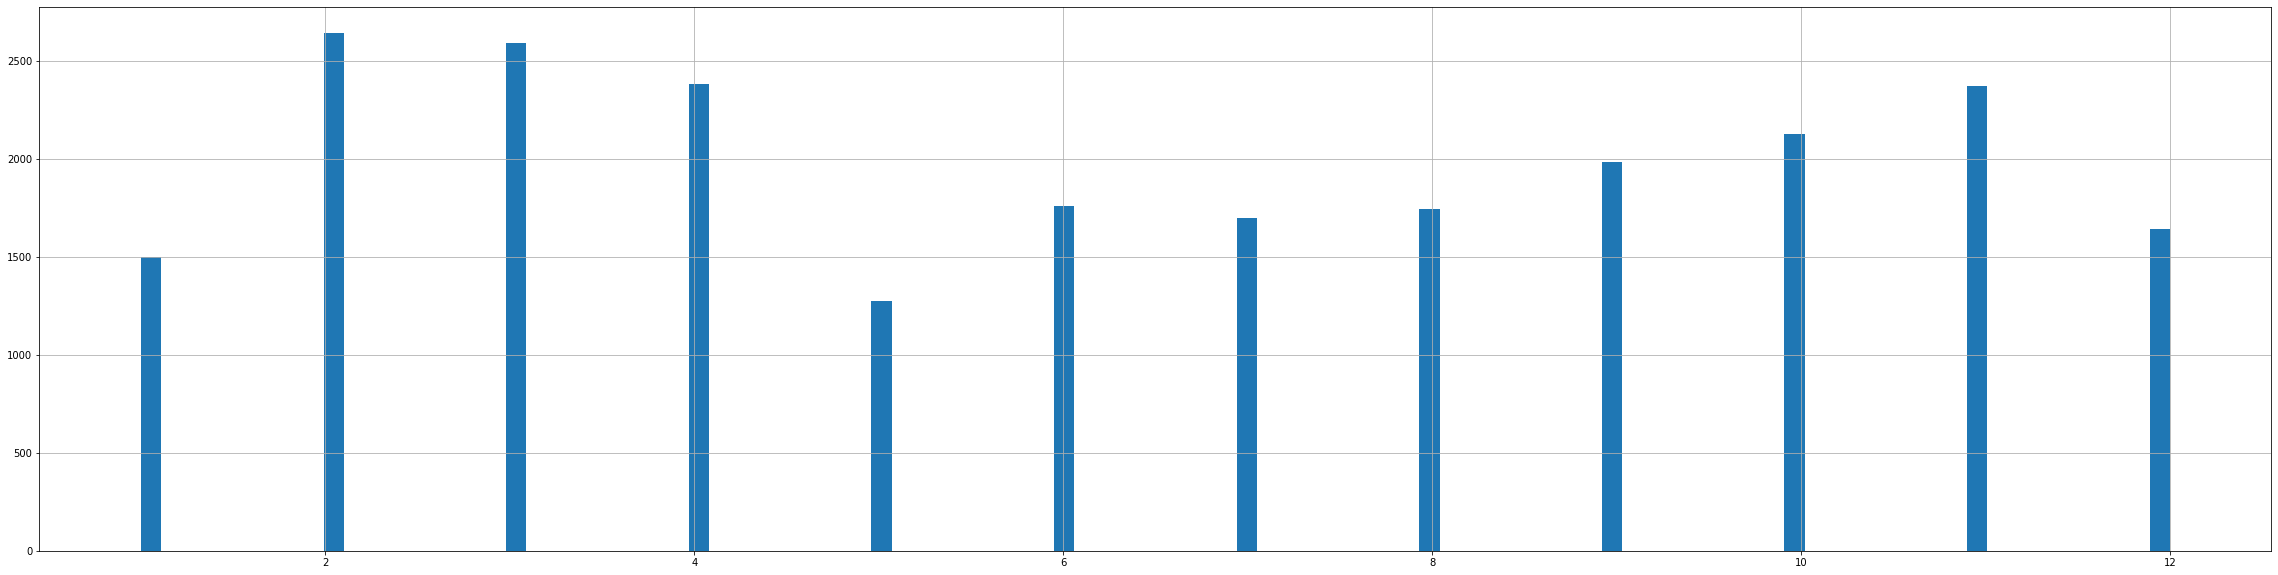

In [46]:
data['month'].hist(bins=100,figsize=(40,10))

Жилье активнее покупают в зимние месяцы, а меньше всего покупок в мае.

#### Как быстро продавались квартиры?

<AxesSubplot:>

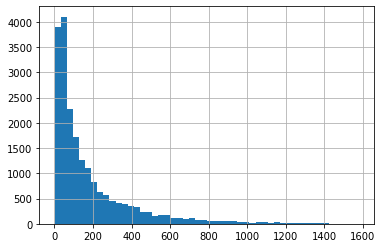

In [47]:
data['days_exposition'].hist(bins=50)

In [48]:
data['days_exposition'].median()

95.0

In [49]:
data['days_exposition'].mean()

180.88863436982163

In [50]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Продажи занимают около 95 дней. Продажи более 232 дней считаются затяжными. Быстрыми можно считать продажи до 45 дней.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

<AxesSubplot:xlabel='total_area'>

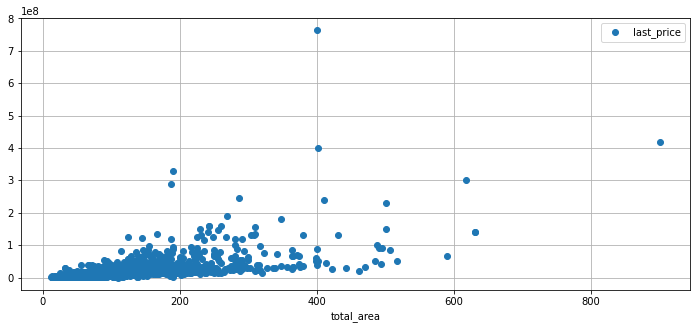

In [51]:
(
data
.plot(x = 'total_area',y='last_price', style = 'o', grid=True, figsize=(12, 5))
)

Коррелляция

In [52]:
data['total_area'].corr(data['last_price'])

0.6536750579657242

Чем больше общая площадь, тем выше цена - это подтверждает и график, и коэффициент корреляции Пирсона. Коррелляция показывает не очень сильную связь(0,6), но все же она есть.

<AxesSubplot:xlabel='living_area'>

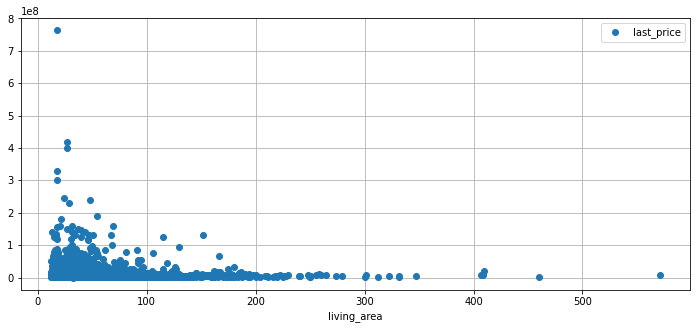

In [53]:
(
data
.plot(x = 'living_area',y='last_price', style = 'o', grid=True, figsize=(12, 5))
)

In [54]:
data['living_area'].corr(data['last_price'])

0.0014934470760337327

Чем больше жилая площадь, тем выше цена, но связи между этими величинами практически нет

<AxesSubplot:xlabel='kitchen_area'>

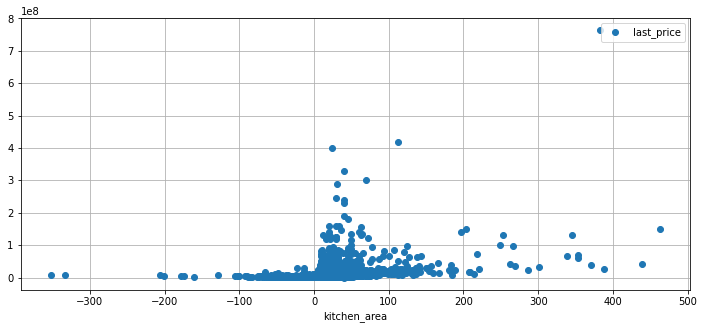

In [55]:
(
data
.plot(x = 'kitchen_area',y='last_price', style = 'o', grid=True, figsize=(12, 5))
)

In [56]:
data['kitchen_area'].corr(data['last_price'])

0.38008006210732975

От площади кухни цена слабо зависит

<AxesSubplot:xlabel='rooms'>

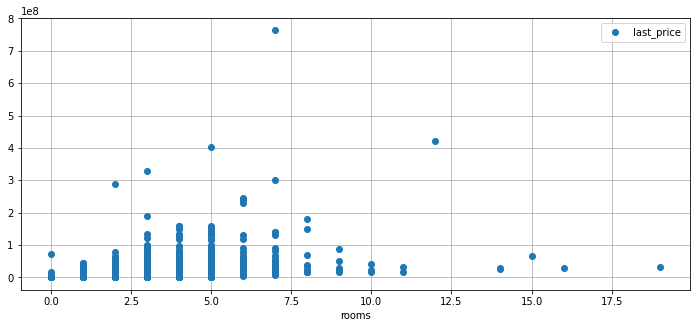

In [57]:
(
data
.plot(x = 'rooms',y='last_price',style = 'o', grid=True, figsize=(12, 5))
)

In [58]:
data['rooms'].corr(data['last_price'])

0.3633428499648948

Цена квартир с количеством комнат от 0 до 2 ниже, чем на квартиры с количеством комнат от 3 до 7. Данные по квартирам с количеством комнат 7+ не являются достоверными, так как их мало в сравнении с другими. Связь между величинами слабая.

<AxesSubplot:xlabel='weekday'>

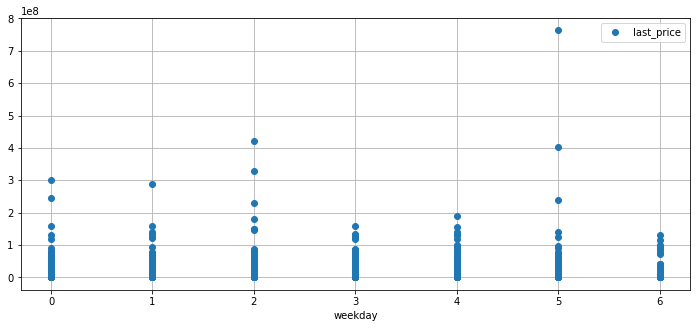

In [59]:
(
data
.plot(x = 'weekday',y='last_price', style = 'o', grid=True, figsize=(12, 5))
)

По времени цена медленно увеличивается.

<AxesSubplot:xlabel='month'>

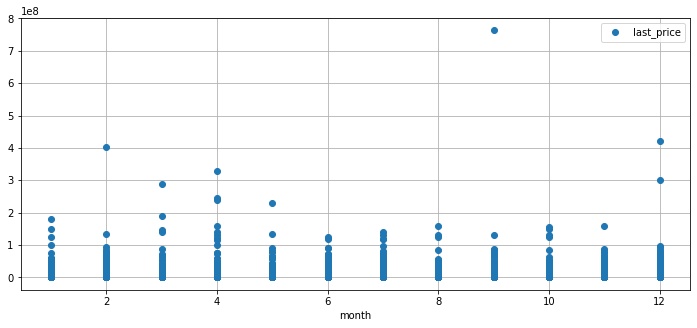

In [60]:
(
data
.plot(x = 'month',y='last_price', style = 'o', grid=True, figsize=(12, 5))
)

In [61]:
data['month'].corr(data['last_price'])

0.0027791287507397166

От месяца цена не зависит

<AxesSubplot:xlabel='year'>

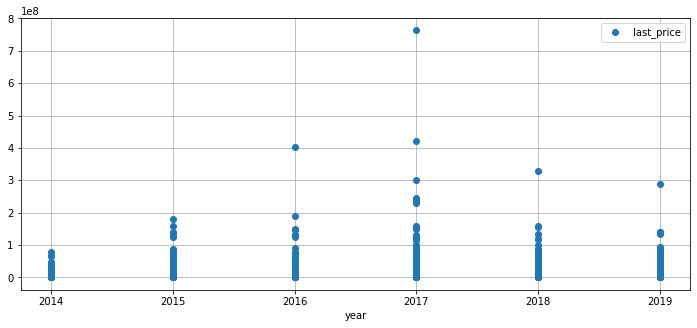

In [62]:
(
data
.plot(x = 'year',y='last_price', style = 'o', grid=True, figsize=(12, 5))
)

In [63]:
data['year'].corr(data['last_price'])

-0.043089036199508615

По графику: с увеличением года, увеличивалась и цена. 
По коэф Пирсона: чем больше год, тем меньше цена, но связь очень слабая, поэтому лучше верить графику

<AxesSubplot:xlabel='type_floor', ylabel='last_price'>

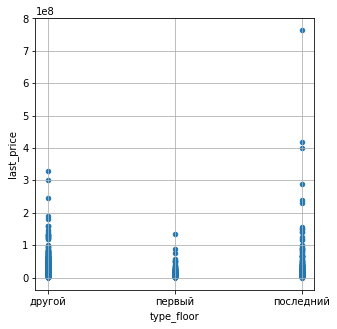

In [64]:
(
data
.plot(x = 'type_floor',y='last_price', style = 'o', grid=True, figsize=(5, 5), kind = 'scatter')
)

На первом этаже жилье преобретают реже всего,поэтому цена тоже ниже. С большей охотой покупают на последнем, цена чуть выше первого этажа. Чаще всего люди предпочитают не последний и не первый этажи и там самые высокие цены.

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name

In [65]:
# 10 населенных пунктов c наибольшим числом объявлений

top_10 = data.groupby('locality_name')['price_metr'].agg(['count']).sort_values(by = 'count',ascending = False).head(10)
top_10

,count
locality_name,
Санкт-Петербург,15721
Мурино,590
Кудрово,472
Шушары,440
Всеволожск,398
Пушкин,369
Колпино,338
Парголово,327
Гатчина,307


In [66]:
#top_10_new - Таблица дата с городами только из топ 10,группировка по названию и нахождение среднего
top_10_new = data.query('locality_name == "Санкт-Петербург" or locality_name == "Мурино" or locality_name == "Кудрово" or locality_name == "Шушары" or locality_name == "Всеволожск" or locality_name == "Пушкин" or locality_name == "Колпино" or locality_name == "Парголово" or locality_name == "Гатчина" or locality_name == "Выборг"').groupby('locality_name').mean()
top_10_new['price_metr']

locality_name
Всеволожск          68654.473986
Выборг              58141.909153
Гатчина             68746.146763
Колпино             75424.579098
Кудрово             95324.930544
Мурино              86087.512050
Парголово           90175.913458
Пушкин             103125.819291
Санкт-Петербург    114849.008794
Шушары              78677.364217
Name: price_metr, dtype: float64

Самая высокая средняя цена за квадратный метр - в Санкт-Петербурге(114 849 р)
На втором месте город Пушкин (103 125 р)
На третьем Кудрово(95 324 р)

Самыми бюджетными оказались: Выборг(58 141 р), Всеволжск(68 654 р) и Гатчина(68 746 р)  

In [67]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,15721,5500000.0
Мурино,590,3400000.0
Кудрово,472,3890000.0
Шушары,440,3950000.0
Всеволожск,398,3450000.0
Пушкин,369,5180000.0
Колпино,338,3600000.0
Парголово,327,4100000.0
Гатчина,307,3100000.0


In [68]:
price_km_mean = data[data['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_nearest_km').agg({'price_metr':'mean'})
price_km_mean

,price_metr
cityCenters_nearest_km,
0.0,245833.530289
1.0,177005.407676
2.0,157849.007329
3.0,121387.453704
4.0,133282.874761
5.0,140509.789046
6.0,151012.193621
7.0,156176.879664
8.0,125671.442742


Чем дальше от центра, тем ниже цена на квадратный метр. Однако, на  27 км цена сильно выделяется.Это может быть связано с продажей очень дорогого жилья.

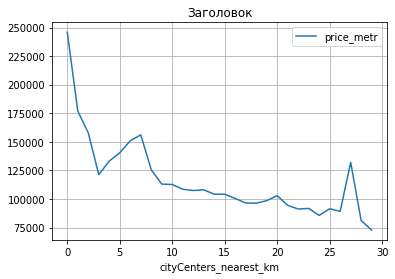

In [70]:
price_km_mean.plot(grid = True, title = 'Заголовок');

Взглянув на график, видно, что цена снижается, однако есть пик в 6 км от города и в 27 км

### Общий вывод

В ходе исследования удалось выяснить:
- Хорошо продаются квартиры с общей площадью от 30 до 100 м2
- Чаще всего люди покупают однокомнатные квартиры
- Потолки имеют разброс от 2,5 до 2,8 метров
- Предпочтительнее квартиры в центре или очень далеко от него, поэтому продают где-то посередине
- На выходных покупки совершаются редко, чаще совершают сделку во вторник или четверг
- Если оценивать по месяцам, то чаще покупают в зимний период, а реже в мае
- Быстрой покупкой можно считать продажу за менее чем 45 дней, а медленной более 232 дней
- Больше всего на цену влияет общая площадь, также можно отследить зависимость цены от количества комнат
- Чем дальше от центра, тем ниже цена
- На первом этаже жилье преобретают реже всего,поэтому цена тоже ниже. С большей охотой покупают на последнем, цена чуть выше первого этажа. Чаще всего люди предпочитают не последний и не первый этажи и там самые высокие цены.